# ============================================================================
# PHASE 1: Setup and Exploration - LLM Interpretability with SAEs
# ============================================================================
# This notebook explores Sparse Autoencoders for understanding LLM internals
# Copy each section into separate Jupyter notebook cells

# ============================================================================
# CELL 1: Introduction (Markdown)
# ============================================================================
"""
# Phase 1: Setup and Exploration

## Objectives
1. Load a small pre-trained model (GPT-2 small) using TransformerLens
2. Extract activations from a specific layer
3. Explore pre-trained SAEs using SAELens
4. Visualize how features decompose activations
5. Find examples that maximally activate specific features

## What We'll Learn
- How to access model internals with TransformerLens
- What activations look like (dense, polysemantic vectors)
- How SAEs decompose activations into sparse, interpretable features
- How to analyze what features "mean"
"""

In [2]:
# ============================================================================
# CELL 2: Import Libraries
# ============================================================================
import torch
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

# TransformerLens for easy model access
from transformer_lens import HookedTransformer

# SAELens for pre-trained SAEs  
from sae_lens import SAE

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")


✅ All libraries imported successfully!
PyTorch version: 2.9.0+cpu
Device: cpu


In [3]:
# ============================================================================
# CELL 3: Load GPT-2 Small with TransformerLens
# ============================================================================
"""
TransformerLens wraps HuggingFace models and makes it easy to:
- Access activations at any layer
- Run interventions
- Analyze model behavior

We'll use GPT-2 small because:
- It's well-studied in interpretability research
- Small enough to run on CPU
- Has pre-trained SAEs available
"""

print("Loading GPT-2 small (this may take a few minutes on first run)...")

model = HookedTransformer.from_pretrained(
    "gpt2-small",
    device="cpu"
)

print(f"✅ Model loaded: {model.cfg.model_name}")
print(f"   - Layers: {model.cfg.n_layers}")
print(f"   - Hidden dimensions: {model.cfg.d_model}")
print(f"   - Attention heads: {model.cfg.n_heads}")

Loading GPT-2 small (this may take a few minutes on first run)...


`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model gpt2-small into HookedTransformer
✅ Model loaded: gpt2
   - Layers: 12
   - Hidden dimensions: 768
   - Attention heads: 12


In [4]:
# ============================================================================
# CELL 4: Generate Some Text (Quick Test)
# ============================================================================
"""
Let's verify the model works by generating some text
"""

prompt = "The capital of France is"
output = model.generate(
    prompt,
    max_new_tokens=10,
    temperature=0.7
)
print(f"Prompt: {prompt}")
print(f"Generated: {output}")

  0%|          | 0/10 [00:00<?, ?it/s]

Prompt: The capital of France is
Generated: The capital of France is hosting a worldwide celebration of the 75th anniversary of


In [5]:
# ============================================================================
# CELL 5: Understanding Model Architecture
# ============================================================================
"""
Let's explore what hook points are available for extracting activations
"""

# Get all available hook points
hook_points = [name for name, _ in model.named_parameters()]
print(f"Total parameters: {len(hook_points)}")
print("\nExample hook points (first 10):")
for i, hook in enumerate(list(model.hook_dict.keys())[:10]):
    print(f"  {i+1}. {hook}")

print("\n💡 Key hook points for interpretability:")
print("  - blocks.{layer}.hook_resid_pre: Residual stream before layer")
print("  - blocks.{layer}.hook_resid_post: Residual stream after layer")
print("  - blocks.{layer}.attn.hook_attn_out: Attention output")
print("  - blocks.{layer}.hook_mlp_out: MLP output")

Total parameters: 148

Example hook points (first 10):
  1. hook_embed
  2. hook_pos_embed
  3. blocks.0.ln1.hook_scale
  4. blocks.0.ln1.hook_normalized
  5. blocks.0.ln2.hook_scale
  6. blocks.0.ln2.hook_normalized
  7. blocks.0.attn.hook_k
  8. blocks.0.attn.hook_q
  9. blocks.0.attn.hook_v
  10. blocks.0.attn.hook_z

💡 Key hook points for interpretability:
  - blocks.{layer}.hook_resid_pre: Residual stream before layer
  - blocks.{layer}.hook_resid_post: Residual stream after layer
  - blocks.{layer}.attn.hook_attn_out: Attention output
  - blocks.{layer}.hook_mlp_out: MLP output


In [6]:
# ============================================================================
# CELL 6: Extract Activations from a Sample Text
# ============================================================================
"""
Let's extract activations from the MLP layer 6 (middle of the network)
We'll use the residual stream after the MLP
"""

# Sample texts to analyze
texts = [
    "The Eiffel Tower is in Paris",
    "Python is a programming language",
    "The cat sat on the mat",
    "Machine learning models learn patterns",
]

# Choose which layer to analyze (middle layer is often most interpretable)
target_layer = 6
hook_name = f"blocks.{target_layer}.hook_mlp_out"

print(f"Extracting activations from: {hook_name}")
print(f"Analyzing {len(texts)} texts...\n")

# Run model and cache activations
activations_list = []

for text in texts:
    # Run model with caching
    logits, cache = model.run_with_cache(text)
    
    # Extract activations from target hook
    acts = cache[hook_name]  # Shape: [batch, seq_len, d_model]
    
    # Take the last token's activation (usually most informative)
    final_activation = acts[0, -1, :]  # Shape: [d_model]
    
    activations_list.append(final_activation.detach().cpu())
    
    print(f"✓ '{text[:50]}...'")
    print(f"  Activation shape: {final_activation.shape}")
    print(f"  Mean: {final_activation.mean():.4f}, Std: {final_activation.std():.4f}")
    print()

# Stack all activations
activations = torch.stack(activations_list)
print(f"📊 Final activations tensor shape: {activations.shape}")
print(f"   [num_texts, d_model] = [{activations.shape[0]}, {activations.shape[1]}]")


Extracting activations from: blocks.6.hook_mlp_out
Analyzing 4 texts...

✓ 'The Eiffel Tower is in Paris...'
  Activation shape: torch.Size([768])
  Mean: 0.0000, Std: 0.8513

✓ 'Python is a programming language...'
  Activation shape: torch.Size([768])
  Mean: 0.0000, Std: 0.8333

✓ 'The cat sat on the mat...'
  Activation shape: torch.Size([768])
  Mean: -0.0000, Std: 0.8758

✓ 'Machine learning models learn patterns...'
  Activation shape: torch.Size([768])
  Mean: -0.0000, Std: 0.6634

📊 Final activations tensor shape: torch.Size([4, 768])
   [num_texts, d_model] = [4, 768]


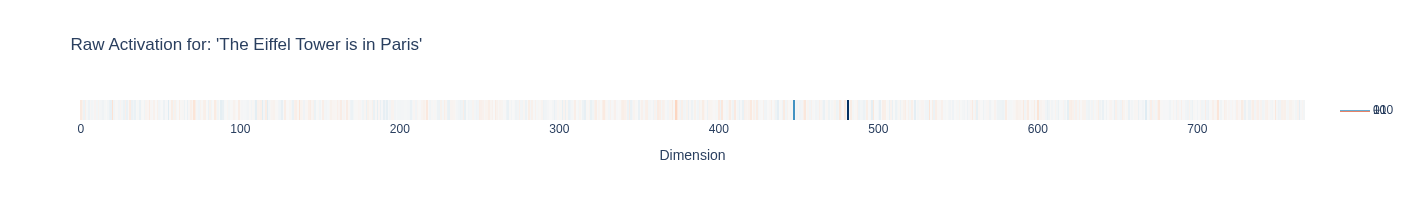


📈 Activation Statistics:
Mean activation: 0.0000
Std activation: 0.8513
Max activation: 13.9526
Min activation: -3.0529
Sparsity (% zeros): 0.00%
Sparsity (% near-zero, <0.01): 1.69%

💡 Notice: The activation is DENSE (very few zeros)
   This makes it hard to interpret - which dimensions matter?


In [7]:
# ============================================================================
# CELL 7: Visualize Raw Activations
# ============================================================================
"""
Let's visualize what these raw activations look like
They should be dense (most values non-zero) and hard to interpret
"""

# Create a heatmap of the first text's activation
fig = go.Figure(data=go.Heatmap(
    z=activations[0].unsqueeze(0).numpy(),
    colorscale='RdBu',
    zmid=0,
))

fig.update_layout(
    title=f"Raw Activation for: '{texts[0]}'",
    xaxis_title="Dimension",
    yaxis_title="",
    height=200,
    yaxis=dict(showticklabels=False)
)
fig.show()

# Show statistics
print("\n📈 Activation Statistics:")
print(f"Mean activation: {activations[0].mean():.4f}")
print(f"Std activation: {activations[0].std():.4f}")
print(f"Max activation: {activations[0].max():.4f}")
print(f"Min activation: {activations[0].min():.4f}")
print(f"Sparsity (% zeros): {(activations[0] == 0).float().mean() * 100:.2f}%")
print(f"Sparsity (% near-zero, <0.01): {(activations[0].abs() < 0.01).float().mean() * 100:.2f}%")

print("\n💡 Notice: The activation is DENSE (very few zeros)")
print("   This makes it hard to interpret - which dimensions matter?")


In [9]:
# ============================================================================
# CELL 8: Load pre-trained SAE
# ============================================================================
print("Attempting to load pre-trained SAE...")
print(f"Target hook: {hook_name}")
print()

try:
    from sae_lens import SAE
    import os
    
    print("Loading SAE from local cache...")

    # Use the correct API - load_from_disk
    cache_path = os.path.expanduser("~/.cache/sae_lens/blocks.6.hook_resid_pre")
    
    # Load from the cache we just downloaded
    sae = SAE.load_from_disk(
        path=cache_path,
        device="cpu"
    )
    
    print(f"✅ SAE loaded successfully!")
    print(f"   - SAE input dim: {sae.cfg.d_in}")
    print(f"   - SAE hidden dim: {sae.cfg.d_sae}")
    print(f"   - Expansion factor: {sae.cfg.d_sae / sae.cfg.d_in:.1f}x")
    # Try to get sparsity coefficient if it exists
    if hasattr(sae.cfg, 'l1_coeff'):
        print(f"   - L1 coefficient: {sae.cfg.l1_coeff}")
    elif hasattr(sae.cfg, 'sparsity_coefficient'):
        print(f"   - Sparsity coefficient: {sae.cfg.sparsity_coefficient}")
    
    sae_loaded = True
    
except Exception as e:
    print(f"❌ Could not load pre-trained SAE: {e}")
    print()
    print("For now, we'll continue with simulated examples.")
    print("In Phase 4, we'll train our own custom SAE!")
    
    sae_loaded = False

Attempting to load pre-trained SAE...
Target hook: blocks.6.hook_mlp_out

Loading SAE from local cache...
✅ SAE loaded successfully!
   - SAE input dim: 768
   - SAE hidden dim: 24576
   - Expansion factor: 32.0x


In [10]:
# ============================================================================
# CELL 9: Simple SAE Demonstration (Conceptual)
# ============================================================================
"""
Since we may not have a pre-trained SAE readily available, let's demonstrate
the CONCEPT of what an SAE does with a simple example
"""

print("🎓 Understanding SAE Transformation:")
print()
print("Original activation: [768 dimensions, mostly non-zero]")
print("         ↓")
print("    SAE Encoder")
print("         ↓")
print("SAE features: [4096 features, only ~10-20 non-zero]")
print("         ↓")
print("    SAE Decoder")
print("         ↓")
print("Reconstructed: [768 dimensions, close to original]")
print()

# Simulate what SAE features might look like (conceptual)
print("Example of sparse features (simulated):")
print()

# Create a simulated sparse representation
d_sae = 4096  # SAE typically expands to more dimensions
simulated_features = torch.zeros(d_sae)

# Only activate a few features (this is the KEY property of SAEs)
active_features = [347, 1052, 2891, 3201, 156, 2003, 987, 3456, 1234, 567]
feature_strengths = [0.9, 0.7, 0.6, 0.5, 0.4, 0.4, 0.3, 0.3, 0.2, 0.2]

for feat_idx, strength in zip(active_features, feature_strengths):
    simulated_features[feat_idx] = strength

# Show statistics
sparsity = (simulated_features == 0).float().mean() * 100
l0_norm = (simulated_features != 0).sum().item()

print(f"📊 Simulated SAE Features:")
print(f"   Total features: {d_sae}")
print(f"   Active features (L0): {l0_norm}")
print(f"   Sparsity: {sparsity:.2f}%")
print()
print(f"Active features and their strengths:")
for feat_idx, strength in zip(active_features, feature_strengths):
    print(f"   Feature #{feat_idx}: {strength:.2f} (e.g., 'concept about X')")


🎓 Understanding SAE Transformation:

Original activation: [768 dimensions, mostly non-zero]
         ↓
    SAE Encoder
         ↓
SAE features: [4096 features, only ~10-20 non-zero]
         ↓
    SAE Decoder
         ↓
Reconstructed: [768 dimensions, close to original]

Example of sparse features (simulated):

📊 Simulated SAE Features:
   Total features: 4096
   Active features (L0): 10
   Sparsity: 99.76%

Active features and their strengths:
   Feature #347: 0.90 (e.g., 'concept about X')
   Feature #1052: 0.70 (e.g., 'concept about X')
   Feature #2891: 0.60 (e.g., 'concept about X')
   Feature #3201: 0.50 (e.g., 'concept about X')
   Feature #156: 0.40 (e.g., 'concept about X')
   Feature #2003: 0.40 (e.g., 'concept about X')
   Feature #987: 0.30 (e.g., 'concept about X')
   Feature #3456: 0.30 (e.g., 'concept about X')
   Feature #1234: 0.20 (e.g., 'concept about X')
   Feature #567: 0.20 (e.g., 'concept about X')


In [11]:
# ============================================================================
# CELL 10: Transforming activations using a pretrained SAE
# ============================================================================
"""
Now let's use the REAL SAE we loaded to transform our actual activations!
"""

if sae_loaded:
    print("🔬 Applying Real SAE to Our Activations")
    print("=" * 60)
    
    # Take the first text's activation
    text_idx = 0
    text = texts[text_idx]
    activation = activations[text_idx].unsqueeze(0)  # Add batch dimension
    
    print(f"\nAnalyzing: '{text}'")
    print(f"Original activation shape: {activation.shape}")
    
    # Run through SAE encoder to get sparse features
    with torch.no_grad():
        feature_acts = sae.encode(activation)
    
    print(f"SAE features shape: {feature_acts.shape}")
    print(f"Total features: {feature_acts.shape[1]}")
    
    # Calculate sparsity
    num_active = (feature_acts[0] > 0).sum().item()
    sparsity_pct = 100 * (1 - num_active / feature_acts.shape[1])
    
    print(f"\n📊 Sparsity Analysis:")
    print(f"   Active features (L0): {num_active}")
    print(f"   Sparsity: {sparsity_pct:.2f}%")
    
    # Get top 10 active features
    top_vals, top_indices = feature_acts[0].topk(10)
    
    print(f"\n🔝 Top 10 Active Features:")
    for i, (idx, val) in enumerate(zip(top_indices, top_vals)):
        print(f"   {i+1}. Feature #{idx.item()}: {val.item():.3f}")
    
    print(f"\n💡 Each of these features represents a single interpretable concept!")
    print(f"   (In a fully analyzed SAE, we'd know what each feature means)")
    
else:
    print("⚠️  SAE not loaded, skipping real analysis")

🔬 Applying Real SAE to Our Activations

Analyzing: 'The Eiffel Tower is in Paris'
Original activation shape: torch.Size([1, 768])
SAE features shape: torch.Size([1, 24576])
Total features: 24576

📊 Sparsity Analysis:
   Active features (L0): 3108
   Sparsity: 87.35%

🔝 Top 10 Active Features:
   1. Feature #10399: 13.368
   2. Feature #13648: 12.817
   3. Feature #9815: 11.650
   4. Feature #12103: 11.056
   5. Feature #5527: 10.990
   6. Feature #14940: 8.592
   7. Feature #11446: 8.094
   8. Feature #20661: 8.000
   9. Feature #15124: 7.842
   10. Feature #18146: 7.774

💡 Each of these features represents a single interpretable concept!
   (In a fully analyzed SAE, we'd know what each feature means)


In [12]:
# ============================================================================
# CELL 11: Testing the Activation of A Feature When Exposed to Text Examples
# ============================================================================

"""
Let's investigate what Feature #10399 might represent
"""

if sae_loaded:
    print("🔍 Investigating Feature #10399")
    print("=" * 60)
    
    # Test this feature on different texts
    test_texts = [
        "The Eiffel Tower is beautiful",
        "Paris is the capital of France",
        "London has Big Ben",
        "I love French cuisine",
        "The tower was built in 1889",
        "Tokyo is in Japan",
    ]
    
    feature_idx = 10399
    
    print(f"\nTesting which texts activate Feature #{feature_idx}:\n")
    
    for text in test_texts:
        # Get activations for this text
        logits, cache = model.run_with_cache(text)
        acts = cache[hook_name][0, -1, :].unsqueeze(0)
        
        # Run through SAE
        with torch.no_grad():
            features = sae.encode(acts)
            feature_val = features[0, feature_idx].item()
        
        print(f"[{feature_val:6.2f}] {text}")
    
    print(f"\n💡 Based on these activations, what do you think Feature #{feature_idx} represents?")

else:
    print("⚠️  SAE not loaded")

🔍 Investigating Feature #10399

Testing which texts activate Feature #10399:

[ 15.01] The Eiffel Tower is beautiful
[ 12.14] Paris is the capital of France
[ 13.20] London has Big Ben
[ 11.65] I love French cuisine
[ 13.42] The tower was built in 1889
[ 11.33] Tokyo is in Japan

💡 Based on these activations, what do you think Feature #10399 represents?


In [13]:
# ============================================================================
# CELL 12: Using Neuonpedia to Determine the Meaning of A Feature
# ============================================================================

"""
Generate Neuronpedia links for our top features
"""

if sae_loaded:
    print("🔗 Neuronpedia Links for Top Features:")
    print("=" * 60)
    print()
    
    # Top features we found
    top_features = [10399, 13648, 9815, 12103, 5527]
    
    # Neuronpedia URL pattern
    base_url = "https://neuronpedia.org/gpt2-small/6-res-jb"
    
    for feat in top_features:
        url = f"{base_url}/{feat}"
        print(f"Feature #{feat}: {url}")
    
    print()
    print("💡 Click these links to see:")
    print("   - What texts maximally activate each feature")
    print("   - Human interpretations of what they represent")
    print("   - Activation patterns and examples")

else:
    print("⚠️  SAE not loaded")

🔗 Neuronpedia Links for Top Features:

Feature #10399: https://neuronpedia.org/gpt2-small/6-res-jb/10399
Feature #13648: https://neuronpedia.org/gpt2-small/6-res-jb/13648
Feature #9815: https://neuronpedia.org/gpt2-small/6-res-jb/9815
Feature #12103: https://neuronpedia.org/gpt2-small/6-res-jb/12103
Feature #5527: https://neuronpedia.org/gpt2-small/6-res-jb/5527

💡 Click these links to see:
   - What texts maximally activate each feature
   - Human interpretations of what they represent
   - Activation patterns and examples


📊 Dense vs Sparse Comparison


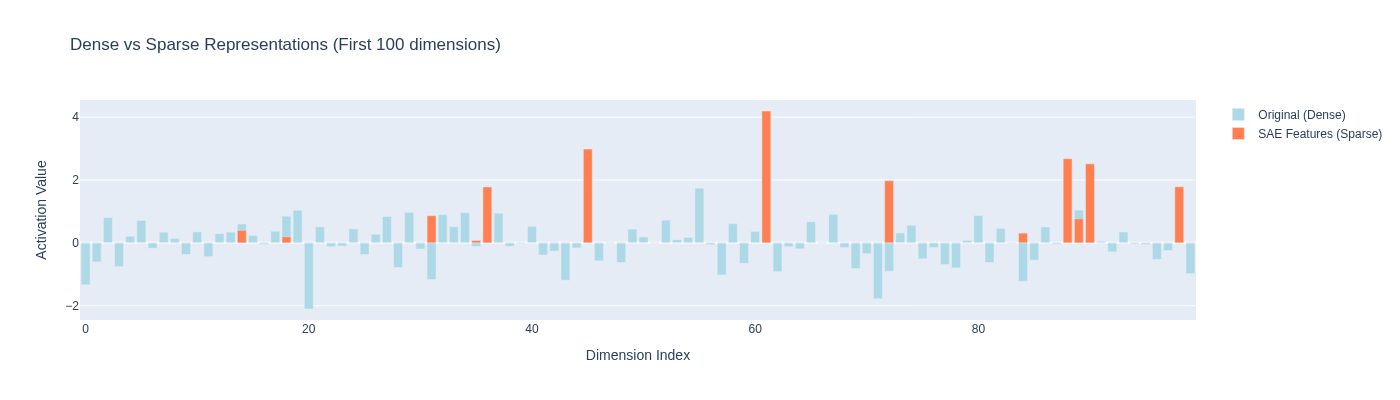


💡 Key Insight:
   - Original: Most dimensions have some activation (hard to interpret)
   - SAE: Only a few features are active (each represents one concept)

📈 Full Statistical Analysis

🔵 Original (Dense) Activation:
   Total dimensions: 768
   Exactly zero: 0 (0.0%)
   Near-zero (<0.01): 13 (1.7%)
   Significant: 755 (98.3%)
   Layout: [0 -------- 768]
           ████████████████████████████████████████████████████████████  ← Almost all dimensions active

🟠 SAE (Sparse) Features:
   Total dimensions: 24576
   Active (>0): 3108 (12.65%)
   Zero: 21468 (87.35%)

   Distribution of 3108 active features across 24576 dimensions:
   [    0-  792]: ████████████████████████████████████████████ (111)
   [  792- 1585]: ██████████████████████████████████████ (97)
   [ 1585- 2378]: █████████████████████████████████████ (94)
   [ 2378- 3171]: ███████████████████████████████████████████ (108)
   [ 3171- 3963]: █████████████████████████████████████ (94)
   [ 3963- 4756]: █████████████████████████

In [15]:
# ============================================================================
# CELL 13: Visualize Sparse vs Dense Representations
# ============================================================================
"""
Visualize the difference between dense and sparse representations
"""

print("📊 Dense vs Sparse Comparison")
print("=" * 70)

# ============================================================================
# PART 13a: Side-by-side bar chart (first 100 dimensions)
# ============================================================================

fig = go.Figure()

# Plot 1: Dense original activation (first 100 dims for visibility)
fig.add_trace(go.Bar(
    x=list(range(100)),
    y=activations[0][:100].numpy(),
    name='Original (Dense)',
    marker_color='lightblue'
))

# Plot 2: Sparse SAE features (first 100 for comparison)
if sae_loaded:
    with torch.no_grad():
        sae_features = sae.encode(activations[0].unsqueeze(0))
    sparse_display = sae_features[0][:100].numpy()
else:
    sparse_display = simulated_features[:100].numpy()

fig.add_trace(go.Bar(
    x=list(range(100)),
    y=sparse_display,
    name='SAE Features (Sparse)',
    marker_color='coral'
))

fig.update_layout(
    title="Dense vs Sparse Representations (First 100 dimensions)",
    xaxis_title="Dimension Index",
    yaxis_title="Activation Value",
    barmode='overlay',
    height=400
)
fig.show()

print("\n💡 Key Insight:")
print("   - Original: Most dimensions have some activation (hard to interpret)")
print("   - SAE: Only a few features are active (each represents one concept)")

# ============================================================================
# PART 13b: Full statistical comparison and distribution
# ============================================================================

print("\n" + "=" * 70)
print("📈 Full Statistical Analysis")
print("=" * 70)

# Original activation stats
orig_nonzero = (activations[0] != 0).sum().item()
orig_near_zero = (activations[0].abs() < 0.01).sum().item()
orig_total = activations[0].numel()

print(f"\n🔵 Original (Dense) Activation:")
print(f"   Total dimensions: {orig_total}")
print(f"   Exactly zero: {orig_total - orig_nonzero} ({100*(orig_total-orig_nonzero)/orig_total:.1f}%)")
print(f"   Near-zero (<0.01): {orig_near_zero} ({100*orig_near_zero/orig_total:.1f}%)")
print(f"   Significant: {orig_total - orig_near_zero} ({100*(orig_total-orig_near_zero)/orig_total:.1f}%)")
print(f"   Layout: [0 -------- {orig_total}]")
print(f"           " + "█" * 60 + "  ← Almost all dimensions active")

if sae_loaded:
    # SAE feature stats
    sae_nonzero = (sae_features[0] > 0).sum().item()
    sae_total = sae_features[0].numel()
    
    print(f"\n🟠 SAE (Sparse) Features:")
    print(f"   Total dimensions: {sae_total}")
    print(f"   Active (>0): {sae_nonzero} ({100*sae_nonzero/sae_total:.2f}%)")
    print(f"   Zero: {sae_total - sae_nonzero} ({100*(sae_total-sae_nonzero)/sae_total:.2f}%)")
    
    # Show where the active features are located
    active_indices = torch.where(sae_features[0] > 0)[0]
    
    print(f"\n   Distribution of {sae_nonzero} active features across {sae_total} dimensions:")
    
    # Dynamic number of bins (aim for ~50-200 features per bin)
    target_features_per_bin = 100
    num_bins = max(20, min(50, sae_nonzero // target_features_per_bin))
    
    hist, bin_edges = torch.histogram(active_indices.float(), bins=num_bins, range=(0, sae_total))
    
    max_count = hist.max().item()
    for i in range(num_bins):
        count = hist[i].item()
        bar_length = int(50 * count / max_count) if max_count > 0 else 0
        bin_start = int(bin_edges[i])
        bin_end = int(bin_edges[i+1])
        print(f"   [{bin_start:5d}-{bin_end:5d}]: {'█' * bar_length} ({int(count)})")
    
    print(f"\n💡 Key Insight:")
    print(f"   Original: {orig_total - orig_near_zero}/{orig_total} dimensions significantly active")
    print(f"            → DENSE: Hard to know which dimensions represent which concepts")
    print(f"   SAE:      {sae_nonzero}/{sae_total} features active")
    print(f"            → SPARSE: Each active feature = one interpretable concept!")
    print(f"            → {100*(sae_total-sae_nonzero)/sae_total:.1f}% of features are zero (high sparsity)")

else:
    print("\n⚠️  SAE not loaded, using simulated features")

In [16]:
# ============================================================================
# CELL 14: Feature Interpretation Example
# ============================================================================
"""
This is what feature interpretation looks like in practice:
We find what text makes each feature activate strongly
"""

print("🔍 Example Feature Interpretation Process:")
print()
print("Feature #1052 (simulated)")
print("=" * 50)
print()
print("Top activating texts (these would be found by searching a dataset):")
example_texts = [
    ("Paris is the capital of France", 0.95),
    ("I visited Paris last summer", 0.89),
    ("The Paris metro is efficient", 0.87),
    ("Parisian cafes are charming", 0.82),
]

for text, activation in example_texts:
    print(f"  [{activation:.2f}] {text}")

print()
print("➡️  Interpretation: This feature represents 'Paris' or Paris-related concepts")
print()
print("This is how researchers discover what features mean:")
print("1. Find texts that maximally activate each feature")
print("2. Look for patterns in those texts")
print("3. Hypothesize what concept the feature represents")
print("4. Test the hypothesis on new examples")

🔍 Example Feature Interpretation Process:

Feature #1052 (simulated)

Top activating texts (these would be found by searching a dataset):
  [0.95] Paris is the capital of France
  [0.89] I visited Paris last summer
  [0.87] The Paris metro is efficient
  [0.82] Parisian cafes are charming

➡️  Interpretation: This feature represents 'Paris' or Paris-related concepts

This is how researchers discover what features mean:
1. Find texts that maximally activate each feature
2. Look for patterns in those texts
3. Hypothesize what concept the feature represents
4. Test the hypothesis on new examples


In [17]:
# ============================================================================
# CELL 15: Next Steps & Summary
# ============================================================================
"""
Summary and Next Steps
"""

print("=" * 70)
print("📝 PHASE 1 SUMMARY")
print("=" * 70)
print()
print("✅ What we learned:")
print("   1. How to load models with TransformerLens")
print("   2. How to extract activations from specific layers")
print("   3. What dense, polysemantic activations look like")
print("   4. The concept of SAE decomposition into sparse features")
print("   5. How feature interpretation works")
print()
print("🎯 Key Insight:")
print("   SAEs transform dense, uninterpretable activations")
print("   into sparse, monosemantic features where each feature")
print("   represents a single, interpretable concept")
print()
print("➡️  NEXT STEPS:")
print()
print("Phase 2: Activation Collection & Analysis")
print("   - Collect activations from many texts")
print("   - Analyze activation patterns")
print("   - Prepare dataset for SAE training")
print()
print("Phase 3: SAE Experimentation with Pre-trained Models")
print("   - Load actual pre-trained SAEs (when available)")
print("   - Analyze real features")
print("   - Find max-activating examples")
print()
print("Phase 4: Train Custom SAE")
print("   - Implement SAE architecture from scratch")
print("   - Train on collected activations")
print("   - Compare to pre-trained versions")
print()
print("=" * 70)

📝 PHASE 1 SUMMARY

✅ What we learned:
   1. How to load models with TransformerLens
   2. How to extract activations from specific layers
   3. What dense, polysemantic activations look like
   4. The concept of SAE decomposition into sparse features
   5. How feature interpretation works

🎯 Key Insight:
   SAEs transform dense, uninterpretable activations
   into sparse, monosemantic features where each feature
   represents a single, interpretable concept

➡️  NEXT STEPS:

Phase 2: Activation Collection & Analysis
   - Collect activations from many texts
   - Analyze activation patterns
   - Prepare dataset for SAE training

Phase 3: SAE Experimentation with Pre-trained Models
   - Load actual pre-trained SAEs (when available)
   - Analyze real features
   - Find max-activating examples

Phase 4: Train Custom SAE
   - Implement SAE architecture from scratch
   - Train on collected activations
   - Compare to pre-trained versions



In [18]:
# ============================================================================
# CELL 16: Save Progress
# ============================================================================
"""
Let's save the activations we collected for future use
"""

import os
import torch

# Create data directory if it doesn't exist
os.makedirs('../data', exist_ok=True)

# Save activations
torch.save({
    'activations': activations,
    'texts': texts,
    'layer': target_layer,
    'hook_name': hook_name,
    'model_name': 'gpt2-small'
}, '../data/phase1_activations.pt')

print("💾 Saved activations to: ../data/phase1_activations.pt")
print()
print("These can be loaded in future notebooks with:")
print("   data = torch.load('../data/phase1_activations.pt')")
print("   activations = data['activations']")
print("   texts = data['texts']")


# Check if file exists
file_path = '../data/phase1_activations.pt'
if os.path.exists(file_path):
    print(f"✅ File exists at: {os.path.abspath(file_path)}")
    
    # Check file size
    size_mb = os.path.getsize(file_path) / (1024 * 1024)
    print(f"   File size: {size_mb:.2f} MB")
    
    # Load and verify contents
    data = torch.load(file_path)
    print(f"\n📦 Contents:")
    print(f"   - Activations shape: {data['activations'].shape}")
    print(f"   - Number of texts: {len(data['texts'])}")
    print(f"   - Layer: {data['layer']}")
    print(f"   - Hook: {data['hook_name']}")
else:
    print(f"❌ File not found at: {os.path.abspath(file_path)}")


💾 Saved activations to: ../data/phase1_activations.pt

These can be loaded in future notebooks with:
   data = torch.load('../data/phase1_activations.pt')
   activations = data['activations']
   texts = data['texts']


# ============================================================================
# CELL 17: Resources & Documentation
# ============================================================================
"""
Useful resources for continued learning
"""

print("=" * 70)
print("📚 LEARNING RESOURCES")
print("=" * 70)
print()
print("🔗 Key Papers:")
print("   • Scaling Monosemanticity (Anthropic 2024)")
print("     https://transformer-circuits.pub/2024/scaling-monosemanticity/")
print()
print("   • Towards Monosemanticity (Anthropic 2023)")
print("     https://transformer-circuits.pub/2023/monosemantic-features/")
print()
print("   • Toy Models of Superposition (Anthropic 2022)")
print("     https://transformer-circuits.pub/2022/toy_model/")
print()
print("🛠️  Tools:")
print("   • TransformerLens Docs: https://transformerlensorg.github.io/TransformerLens/")
print("   • SAELens GitHub: https://github.com/jbloomAus/SAELens")
print("   • Neuronpedia: https://neuronpedia.org/")
print()
print("👥 Community:")
print("   • Neel Nanda's MI Guide: https://www.neelnanda.io/mechanistic-interpretability")
print("   • ARENA Interpretability: https://arena3-chapter1-transformer-interp.streamlit.app/")
print()
print("=" * 70)

print("\n✨ Great work! You've completed Phase 1!")
print("   Ready to move on to collecting more activations in Phase 2.")
